# Test of Bayesian Markov-Chain Monte-Carlo Method with ARCS Data

This data was supplied by Garrett Granroth from the SNS / Oak Ridge National Laboratory.

The data reduction was done in Mantid, preserving events, and the events are imported from a nexus autoreduced file.  
As such, the events do have some histogram artefacts from the way that the weights are computed.
I'm not sure if this can be entirely avoided with pixelated detectors, but in an ideal world we'd compute the event weighting factors without using histograms at all.

/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5
Calculating KDE
   - linear scale
nx 224
slice size 0.5880000000000001


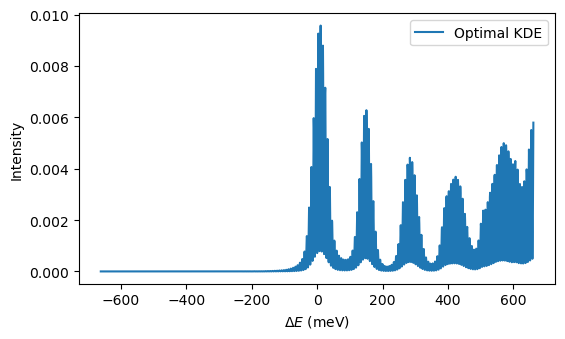

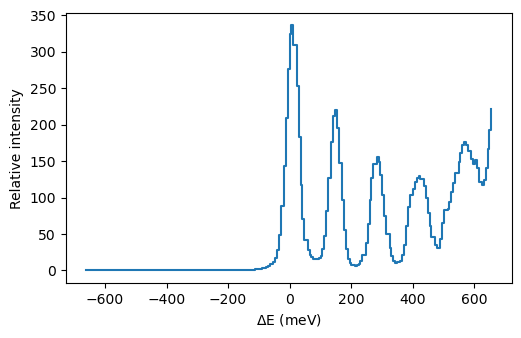

In [33]:
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("error")

# Uncomment the following to make random things reproducable
# (useful for paper figures etc)
# In theory this should work, but for some reason the later analyses are shifting around

RANDOM_SEED = 0
np.random.seed(seed=RANDOM_SEED)

import lmfit 

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform

import copy


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, importlib lets us change the source and force reload of the emtk package.
# However, whilst the error reporting line number is right, the printout of
# the offending source code is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

# We need a full data KDE for later...
ema1.plot_kde(log=False, loglog=False, xlabel='$\Delta E$ (meV)')

#ema1.plot_histogram(loglog=False, log=False, xlabel='meV')

# Manually replot and save histo figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.savefig('arcsFigs/arcs_data_histo.png', dpi=600, bbox_inches='tight')
plt.show()


Least squares model function defined.
['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


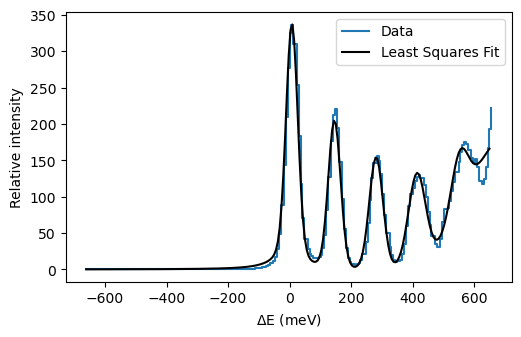

In [18]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)
    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)


ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

lse_starting_parameters = copy.deepcopy(ema1.least_squares_parameters)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
#ema1.plot_LSE_fit(loglog=False, log=False, xlabel='meV', save="/Users/phillipbentley/Code/python/mle/arcs_lse_fit.png")

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

detailed_fit_params = pvals

psigs = ema1.get_lse_param_errors()
print(psigs)

detailed_fit_sigmas = psigs

# Manually replot and save figure for a paper
bn=ema1.optimal_n_bins()
hst = np.histogram(ema1.data, bins=bn, weights=ema1.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post', label='Data')
nhy = hy.size
shy = np.sum(hy)
nly = ema1.lse_result.best_fit.size
sly = np.sum(ema1.lse_result.best_fit)

scl = shy * nly / (nhy * sly)

ax.plot(ema1.histx, scl*ema1.lse_result.best_fit, color='black', label='Least Squares Fit')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.legend()
plt.savefig('arcsFigs/arcs_data_lse.png', dpi=600, bbox_inches='tight')
plt.show()


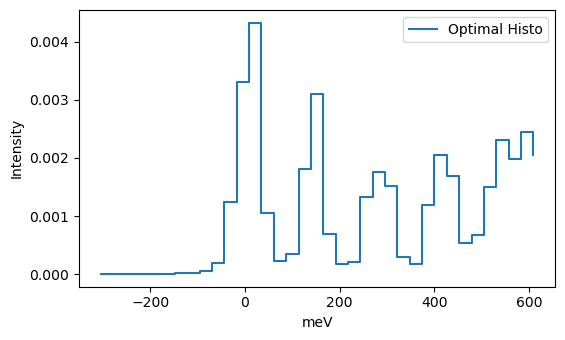

Calculating KDE
   - linear scale
nx 36
slice size 2.6108108108108112


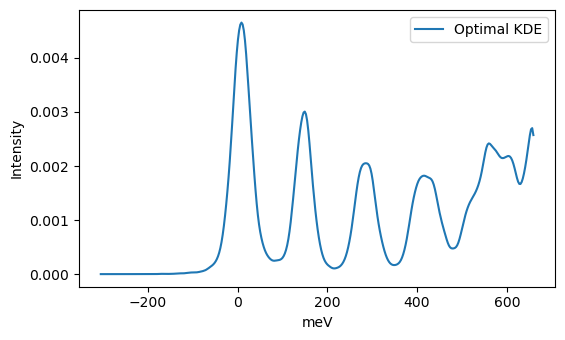

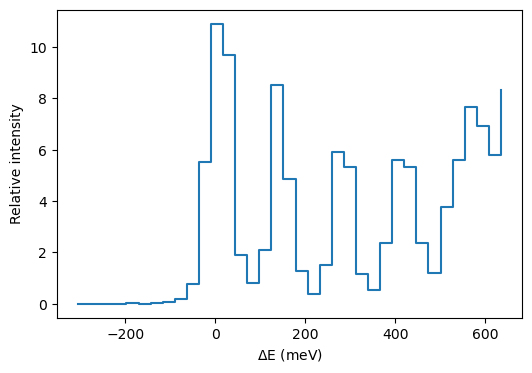

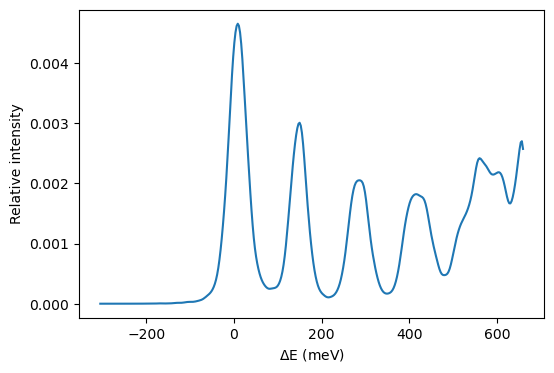

In [19]:
cpo = ema1.subsample(30000)
cpo.plot_histogram(loglog=False,log=False, xlabel='meV')
cpo.plot_kde(loglog=False,log=False, xlabel='meV', method='fdr')

# Manually replot and save figure for a paper
bn=cpo.optimal_n_bins()
hst = np.histogram(cpo.data, bins=bn, weights=cpo.weights)
hx=hst[1]
hy=hst[0]
# wipe over zero value artefacts
zind = np.where(hy==0.0)
for i in range(0, hx.size):
    if i > 0 and np.isin(i, zind):
        hy[i] = hy[i-1]
hx = hx[:-1]
fig,ax=plt.subplots()
ax.step(hx, hy, where='post')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_histo.png', dpi=600, bbox_inches='tight')
plt.show()

fig,ax=plt.subplots()
plt.plot(cpo.kdex, cpo.kdey)
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde.png', dpi=600, bbox_inches='tight')
plt.show()

In [20]:
# Build MCMC Models with API

def simplex_weights(Qraw: np.ndarray) -> np.ndarray:
    # Raw Q values can run between 0-1 to keep things simple
    # The sum is assumed to be 1, preventing out of gamut values
    # That condition is enforced already in the last 4 terms of 
    # the log_prior above.
    # Note that Qraw has one dimension fewer
    # than the number of parameters, like this:
    # https://en.m.wikipedia.org/wiki/Ternary_plot
    
    Qraw = np.asarray(Qraw)
    
    Qsum = np.sum(Qraw)    
    Qlast = 1.0 - Qsum
    
    Qvals = np.append(Qraw, Qlast)
    return Qvals

def log_prior_function(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    if -100.0 < elmu < 100.0 and \
        100.0 < mu1  < 200.0 and \
        200.0 < mu2  < 350.0 and \
        350.0 < mu3  < 450.0 and \
        500.0 < mu4  < 620.0 and \
        600.0 < mubg1< 700.0 and \
        0.0   < mubg2< 200.0 and \
        10.0 < elsigma < 100.0 and \
        10.0 < s1 < 100.0 and \
        10.0 < s2 < 100.0 and \
        10.0 < s3 < 100.0 and \
        10.0 < s4 < 100.0 and \
        100.0 < sbg1 < 250.0 and \
        10.0  < sbg2 < 250.0 and \
        0.1 < m1 < 1.0 and\
        0.1 < m2 < 1.0 and\
        0.1 < m3 < 1.0 and\
        0.1 < m4 < 1.0 and\
        0.1 < mbg1 < 1.0 and\
        0.1 < mbg2 < 1.0 and\
        m1 + m2 + m3 + m4 + mbg1 + mbg2 < 1.0:
        return 0.0
    
    return -np.inf



def probability_mass_function(theta, xx, xmin, xmax, pweights, verbose=False):
    
    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(xx)
    else:
        use_weights = pweights

    spscale = xmax-xmin


    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(xx, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(xx, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(xx, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(xx, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(xx, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(xx, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(xx, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = (el + l1 + l2 + l3 + l4 + bg1 + bg2)**use_weights
    
    return sol



def log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False):

    raiseError = False
    result = 0.0

    elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2 = theta

    pweights = np.asarray(pweights)
    
    if (pweights==None).any():
        use_weights = np.ones_like(data)
    else:
        use_weights = pweights
        
    
    lp = mylpf(theta)
    
    if np.isinf(lp):
        return -np.inf

    mvals = simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))
    


    el = mvals[0] * norm.pdf(data, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)
    l1 = mvals[1] * norm.pdf(data, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(data, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(data, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(data, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(data, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(data, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)


    # Guard against zero values in each term
    minval = 1.0E-300

    msk = el < minval
    el[msk] = minval

    msk = l1 < minval
    l1[msk] = minval

    msk = l2 < minval
    l2[msk] = minval

    msk = l3 < minval
    l3[msk] = minval

    msk = l4 < minval
    l4[msk] = minval

    msk = bg1 < minval
    bg1[msk] = minval

    msk = bg2 < minval
    bg2[msk] = minval

    
 #   try:
    lel = np.log(el)
    ll1 = np.log(l1)
    ll2 = np.log(l2)
    ll3 = np.log(l3)
    ll4 = np.log(l4)
    lbg1 = np.log(bg1)
    lbg2 = np.log(bg2)

    lt1 = np.logaddexp(lel, ll1)
    lt2 = np.logaddexp(lt1, ll2)
    lt3 = np.logaddexp(lt2, ll3)
    lt4 = np.logaddexp(lt3, ll4)
    lt5 = np.logaddexp(lt4, lbg1)
    lt6 = np.logaddexp(lt5, lbg2)

    lll = np.sum(lt6 * use_weights)
    
    result = lp + lll

    if np.isnan(result):
        print("NaN in log_likelihood at", theta)
        verbose=True
                    
    if verbose==True:
        print("lp", lp)
        print("lll", lll)
        print("l1", l1)
        print("l2", l2)
        print("l3", l3)
        print("l4", l4)
        print("bg1", bg1)
        print("bg2", bg2)
        print("")
        print("m0", mvals[0])
        print("m1", mvals[1])
        print("m2", mvals[2])
        print("m3", mvals[3])
        print("m4", mvals[4])
        print("m5", mvals[5])
        print("m6", mvals[6])

    return result

    
#   except RuntimeWarning as e:
#        print("Runtime warning at", theta)
#        print(e)
#        raise
    


cpo.lpf = log_prior_function
cpo.pmf = probability_mass_function
cpo.llf = log_likelihood_function

# Seed MCMC search manually
# ema1.make_lse_params(
#    amplitude=dict(value=1.0, min=0.0),\
#    elmu = dict(value=10.0, min=-100.0, max=100.0),\
#    mu1 = dict(value=150.0, min=100.0, max=200.0),\
#    mu2 = dict(value=280.0, min=200.0, max=350.0),\
#    mu3 = dict(value=420.0, min=350.0, max=450.0),\
#    mu4 = dict(value=560.0, min=500.0, max=620.0),\
#    mubg1=dict(value=620.0, min=600.0, max=700.0),\
#    mubg2=dict(value=140.0, min=0.0, max=200.0),\

#    elsigma = dict(value=20.0, min=10.0, max=100.0),\
#    s1 = dict(value=30.0, min=10.0, max=100.0),\
#    s2 = dict(value=30.0, min=10.0, max=100.0),\
#    s3 = dict(value=30.0, min=10.0, max=100.0),\
#    s4 = dict(value=30.0, min=10.0, max=100.0),\
#    sbg1=dict(value=100.0, min=100.0, max=250.0),\
#    sbg2=dict(value=20.0, min=10.0, max=250.0),\
#    m1=dict(value=0.3, min=0.0, max = 1.0),\
#    m2=dict(value=0.2, min=0.0, max = 1.0),\
#    m3=dict(value=0.15, min=0.0, max = 1.0),\
#    m4=dict(value=0.1, min=0.0, max = 1.0),\
#    mbg1=dict(value=0.1, min=0.0, max=1.0),\
#    mbg2=dict(value=0.1, min=0.0, max=1.0)
#)

same_as_least_squares = np.array([10.0, 150.0, 280.0, 420.0, 560.0,\
                                 620.0, 140.0, 20.0, 30.0, 30.0,\
                                 30.0, 30.0, 100.0, 20.0,\
                                 0.3, 0.2, 0.15, 0.1, 0.1, 0.1])

#cpo.theta_seed = np.array([7.83319976e+00, 1.45695047e+02, 2.81254328e+02,\
# 4.14035526e+02, 5.52327378e+02, 6.99999691e+02, 2.30190791e-02,\
# 1.86422670e+01, 1.99165093e+01, 2.21066916e+01, 2.75136714e+01,\
# 2.79613790e+01, 1.16801601e+02, 4.02817313e+01, 1.90420268e-01,\
# 1.40207127e-01, 1.18191129e-01, 1.18351136e-01, 7.89817013e-02,\
# 2.74781599e-01])

nan_location = np.array([9.99999112e+00, 1.49999991e+02, 2.80000003e+02, 4.20000001e+02,\
 5.60000002e+02, 6.20000016e+02, 1.39999999e+02, 2.00000157e+01,\
 2.99999882e+01, 3.00000001e+01, 3.00000015e+01, 3.00000010e+01,\
 1.00000001e+02, 2.00000099e+01, 2.99987259e-01, 2.00008231e-01,\
 1.50005576e-01, 1.00000433e-01, 1.00000804e-01, 1.00002444e-01])

cpo.theta_seed = same_as_least_squares

# Seed MCMC search with LSE fit
#cpo.lse_fit()
#cpo.theta_seed = detailed_fit_params # <- this takes parameters from the detailed fit done earlier
#cpo.theta_seed = cpo.theta_seed[1:]

#log_likelihood_function(theta, data, xmin, xmax, pweights, mylpf, verbose=False)
#test=log_likelihood_function(nan_location, ema1.data, np.amin(ema1.data), np.amax(ema1.data), ema1.weights, log_prior_function, verbose=True)

cpo.nwalkers=32 # need to increase this to improve sampling stats quality 
# (see plots of MCMC_parameter_distribution later) 

cpo.MCMC_fit(nburn=150, niter=150) # fixed number of iterations
#cpo.MCMC_fit(niter=5000, convergence="Gelman-Rubin") # gelman-rubin method to check for convergence


MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:21<00:00,  6.99it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:21<00:00,  7.02it/s]

MCMC sampling complete.


(150, 41, 20)
(150, 41, 20)


True

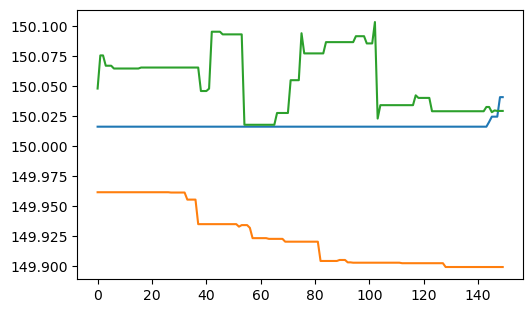

In [21]:
chz = cpo.sampler.get_chain()
nwk = cpo.nwalkers
ndm = cpo.ndim

rlen = chz.shape[0]

print(chz.shape)

burned = chz[-1000::]
#=np.delete(chz, np.s_[rlen-42:rlen], axis=0)
print(burned.shape)
ch1 = burned[:,1,1]
ch2 = burned[:,2,1]
ch3 = burned[:,3,1]
fig,ax=plt.subplots()
ax.plot(ch1)
ax.plot(ch2)
ax.plot(ch3)

cpo.self_check()

In [22]:
# The standard deviation is the square root of the variance.
# Therefore, the variance should be the standard deviation squared.

chz = cpo.sampler.get_chain()
nw = float(cpo.nwalkers)
nd = float(cpo.ndim)
ns = float(chz.shape[0])

print(chz.shape)

mns = np.mean(chz, axis=0)
print("mean shape", mns.shape)
gmn = np.mean(mns, axis=0)
print("gmn  shape", gmn.shape)


wch_variance = 1.0 / (ns - 1.0) * np.sum( (chz - mns)**2.0, axis=0)
print("wchv shape", wch_variance.shape)
wch_var_alt = np.std(chz, axis=0)**2.0
print("w alt shape", wch_var_alt.shape)


bch_variance = ns/(nw - 1.0) * np.sum( (mns - gmn)**2.0, axis=0)
print("bchv shape", bch_variance.shape)

print(bch_variance)

bch_alt_variance = np.std(mns, axis=0)**2.0
print("b alt shape", bch_alt_variance.shape)
print(bch_alt_variance)


ww = (1.0 / nw) * np.sum(wch_variance, axis=0)

wwalt = np.mean(wch_var_alt, axis=0)

print("ww shape", ww.shape)
print("wwalt sh", wwalt.shape)

print("ww", ww)
print("wwalt", wwalt)

t1 = (ns-1.0)*ww / ns
t2 = bch_variance / ns

t1alt = (ns-1.0) * wwalt / ns
t2alt = (bch_alt_variance)

print("t1 shape", t1.shape)
print("t2 shape", t2.shape)

grstat = (t1 + t2) / ww
print(grstat)

gralt = (t1alt + t2alt) / wwalt
print(gralt)


(150, 41, 20)
mean shape (41, 20)
gmn  shape (20,)
wchv shape (41, 20)
w alt shape (41, 20)
bchv shape (20,)
[0.40061789 0.75161595 2.08190058 0.75591304 0.22616047 0.38152114
 0.29329396 2.9224518  1.16089175 0.53513795 0.97674009 0.81052084
 1.31076209 0.28838555 0.49552305 0.13130776 0.18331668 0.01571945
 0.24759827 0.07883825]
b alt shape (20,)
[0.00260564 0.00488856 0.01354082 0.00491651 0.00147096 0.00248144
 0.0019076  0.01900782 0.00755052 0.00348057 0.00635278 0.00527168
 0.00852528 0.00187568 0.00322291 0.00085403 0.0011923  0.00010224
 0.0016104  0.00051277]
ww shape (20,)
wwalt sh (20,)
ww [7.72654674e-04 8.46556240e-04 2.83636567e-03 1.12384191e-03
 2.73743542e-04 1.40446169e-03 8.07373604e-04 5.44347414e-03
 3.48056303e-03 1.17160998e-03 1.23808463e-03 1.53517599e-03
 2.29836925e-03 6.60799429e-04 7.23499733e-04 2.91498883e-04
 1.47094462e-04 2.02042890e-05 4.66324009e-04 7.83323209e-05]
wwalt [7.67503643e-04 8.40912532e-04 2.81745656e-03 1.11634963e-03
 2.71918585e-04 1

In [23]:
  def gsdev(mcmcObject, burn=50) -> np.ndarray :

        # Something is a bit wrong with this.
        # The statistic is starting out at a value of 2
        # in the ARCS test notebook and gently increasing
        # It should not be behaving in this way, there is obviously
        # a mistake in the maths below...

        chains = mcmcObject.sampler.get_chain(discard=burn)
            
        nwk = mcmcObject.nwalkers # "J"
        ndm = mcmcObject.ndim
        nsamps = chains.shape[0] #"L"

        chain_mean = np.mean(chains, axis=0)        
        grand_mean = np.mean(chain_mean, axis=0)

        within_chain_variance = 1.0 / (nsamps - 1.0) * np.sum( (chains - grand_mean)**2.0, axis=0)
        between_chain_variance = nsamps/(nwk - 1.0) * np.sum( (chain_mean - grand_mean)**2.0, axis=0)
        
        ww = (1.0 / nwk) * np.sum(within_chain_variance, axis=0)
        
        t1 = (nsamps-1.0)*ww / nsamps
        t2 = between_chain_variance / nsamps
        
        grstat = (t1 + t2) / ww
        
        return grstat

gs0 = gsdev(cpo, burn=0)
gs10 = gsdev(cpo, burn=10)
gs50 = gsdev(cpo, burn=50)
gs100= gsdev(cpo, burn=100)
gs150= gsdev(cpo, burn=150)

print(gs0)
print(gs10)
print(gs50)
print(gs100)
print(gs150)

[1.77983317 1.86206403 1.83613673 1.82309342 1.85264897 1.64507942
 1.71014099 1.78600688 1.69171366 1.75636501 1.84636262 1.78305642
 1.79643232 1.74755866 1.82585607 1.75370142 1.90034766 1.84443104
 1.78405599 1.87735432]
[1.79078113 1.87718719 1.84632093 1.83607508 1.85957423 1.66297087
 1.72913713 1.80236084 1.70630504 1.76724848 1.86516125 1.79068291
 1.80399536 1.76452332 1.83678576 1.76861762 1.90618493 1.86172556
 1.80038571 1.88759328]
[1.85383554 1.91161495 1.86501759 1.88927301 1.89936666 1.75728142
 1.83480496 1.85206146 1.78984327 1.80781661 1.90117431 1.82274842
 1.82431716 1.86462545 1.87057918 1.86504796 1.91696391 1.91029535
 1.90836344 1.91495622]
[1.8903265  1.92748427 1.92386746 1.9189446  1.92968985 1.82512127
 1.89183629 1.88464937 1.85543167 1.83579372 1.9369512  1.85994106
 1.86656384 1.92377028 1.90297609 1.9352235  1.91191837 1.92948875
 1.95516579 1.9472997 ]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]


/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2024/62179585.py:23: RuntimeWarning: invalid value encountered in divide
  t1 = (nsamps-1.0)*ww / nsamps


Calculating KDE
   - linear scale
nx 36
slice size 2.6108108108108112


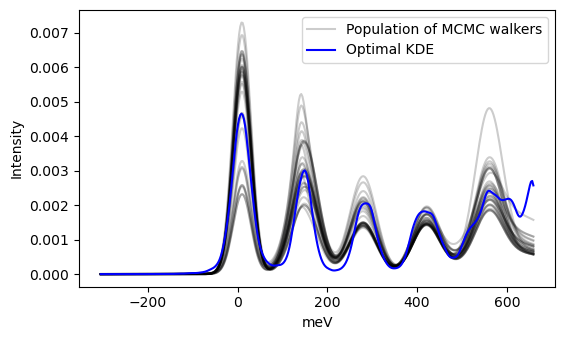

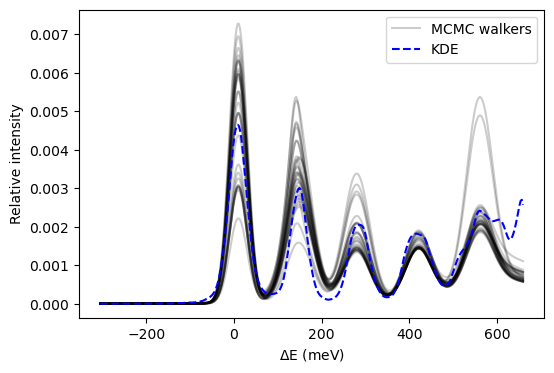

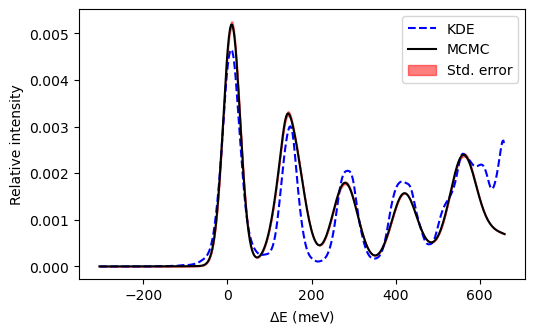

In [24]:
#cpo.plot_LSE_fit(loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method="histo", loglog=False, log=False, xlabel='meV', save="arcs_mcmc_fit.png")

cpo.self_check()

cpo.plot_MCMC_fit(method='kde', loglog=False, log=False, xlabel='meV')
#cpo.plot_MCMC_fit(method='histo', loglog=False, log=False, xlabel='meV')

# Repeat plot manually for paper output

flt = cpo.sampler.get_chain(discard=20, thin=15, flat=True)
inds  = np.random.choice(len(flt), size=30, replace=False)
pt_sum = np.sum(cpo.kdey)

fig,ax=plt.subplots()

for ind in inds:
    smp = flt[ind]
    yfit = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)
    ysum = np.sum(yfit)
    scale = pt_sum / ysum
    yfit = yfit * scale

    if ind == inds[0]:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2, label='MCMC walkers')
    else:
        ax.plot(cpo.kdex, yfit, color='black', alpha=0.2)

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit.png', dpi=600, bbox_inches='tight')
plt.show()

# Plot showing the average of the PDFs over all walkers?
inds = np.arange(len(flt))

yfit = np.zeros((len(inds),cpo.kdex.size))

for ind in inds:
    smp = flt[ind]
    yfit[ind] = cpo.pmf(smp, cpo.kdex, cpo.xmin, cpo.xmax, None)

ymean = np.mean(yfit, axis=0)
ystd = np.std(yfit, axis=0)
ystd = ystd / np.sqrt(len(inds))

                
ysum = np.sum(ymean)
scale = pt_sum / ysum
ymean = ymean * scale
ystd = ystd * scale

plt.plot(cpo.kdex, cpo.kdey, ls='--', color='blue', label='KDE')
plt.plot(cpo.kdex, ymean, color='black', label='MCMC')
plt.fill_between(cpo.kdex, ymean-ystd, ymean+ystd, color='red', alpha=0.5, label='Std. error')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
#plt.xlim([410, 435])
#plt.ylim([0.0014, 0.00195])
plt.legend()
fig.set_size_inches(6,4)
plt.savefig('arcsFigs/arcs_data_subsampled_kde_fit_mean.png', dpi=600, bbox_inches='tight')
plt.show()

stdd 0.05807881259255674
stdd 0.07569327270919537
stdd 0.12789946570769314
stdd 0.07767146965864083
stdd 0.04174782593961108
stdd 0.06226184179987058
stdd 0.05205376199031357
stdd 0.15625300288372707
stdd 0.10491841947307373
stdd 0.06814962397789746
stdd 0.0870781936311466
stdd 0.08244162636904197
stdd 0.1039631120071338
stdd 0.05031970240524518
stdd 0.06278208803772899
stdd 0.033817003843750214
stdd 0.03658438762440554
stdd 0.011059381639508318
stdd 0.0455369126506689
stdd 0.024301836063238692
149.9716477706063 +/- 0.0009652053602987135 using method mean


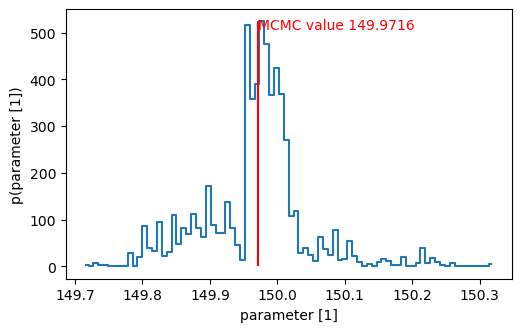

fwhm 3.19642067736185
fwhm 8.56119081954391
fwhm 5.15171277997365
fwhm 5.402706027060269
fwhm 3.1421739130434787
fwhm 3.4827290893519915
fwhm 4.780701754385966
fwhm 7.551296720061021
fwhm 3.349753694581281
fwhm 2.897173582863431
fwhm 4.662802142947534
fwhm 1.4768126731389657
fwhm 1.202247191011236
fwhm 3.1599378881987583
fwhm 2.3133033033033037
fwhm 2.557450106010325
fwhm 1.743481799556566
fwhm 1.6367816091954008
fwhm 1.223809523809523
fwhm 1.7022471910112351
149.97704343068438 +/- 0.0642679359081775 using method peak


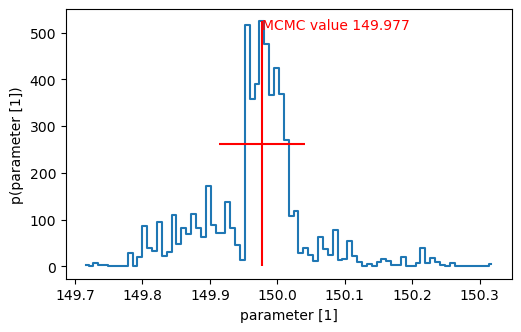

In [25]:
lookat=1
#cpo.plot_MCMC_parameter_distribution(lookat, compare=True)
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='mean', savename='arcsFigs/arcs_parameter_mean.png')
cpo.plot_MCMC_parameter_distribution(lookat, compare=False, method='peak', savename='arcsFigs/arcs_parameter_peak.png')


In [26]:
print("PEAK METHOD:")
mcpparams, mcperr = cpo.get_MCMC_parameters(method='peak')
print(mcpparams)
print(mcperr)

print()
print("MEAN METHOD:")
mcparams, mcerr = cpo.get_MCMC_parameters(method='mean')
print(mcparams)
print(mcerr)

print()
print("LSE on full data set")
lsparams = ema1.get_lse_param_values()


lserrors = ema1.get_lse_param_errors()
print(lsparams)
print(lserrors)

import pandas

pn = ema1.get_lse_param_names()
pn = pn[1:]

df = pandas.DataFrame({"PARAMETER": pn, "LSE": lsparams[1:], "LSE_ERR": lserrors[1:], "BAYES": mcparams, "BAYES_ERR": mcerr, "BAYES-PEAK": mcpparams, "BAYES-PEAK-ERR": mcperr})
print(df)

PEAK METHOD:
fwhm 3.19642067736185
fwhm 8.56119081954391
fwhm 5.15171277997365
fwhm 5.402706027060269
fwhm 3.1421739130434787
fwhm 3.4827290893519915
fwhm 4.780701754385966
fwhm 7.551296720061021
fwhm 3.349753694581281
fwhm 2.897173582863431
fwhm 4.662802142947534
fwhm 1.4768126731389657
fwhm 1.202247191011236
fwhm 3.1599378881987583
fwhm 2.3133033033033037
fwhm 2.557450106010325
fwhm 1.743481799556566
fwhm 1.6367816091954008
fwhm 1.223809523809523
fwhm 1.7022471910112351
[9.99691184e+00 1.49977043e+02 2.79993907e+02 4.19997028e+02
 5.59998951e+02 6.19997927e+02 1.39984439e+02 2.00011885e+01
 3.00019740e+01 2.99696440e+01 2.99949561e+01 2.99947852e+01
 1.00000004e+02 1.99990594e+01 2.92344079e-01 2.01279707e-01
 1.00000474e-01 1.00001195e-01 1.00000037e-01 1.00017382e-01]
[0.02399519 0.06426794 0.03867335 0.04055753 0.02358796 0.02614447
 0.03588821 0.05668677 0.02514624 0.02174877 0.03500315 0.01108627
 0.00902514 0.02372131 0.01736572 0.0191985  0.01308813 0.01228714
 0.00918701 0.01

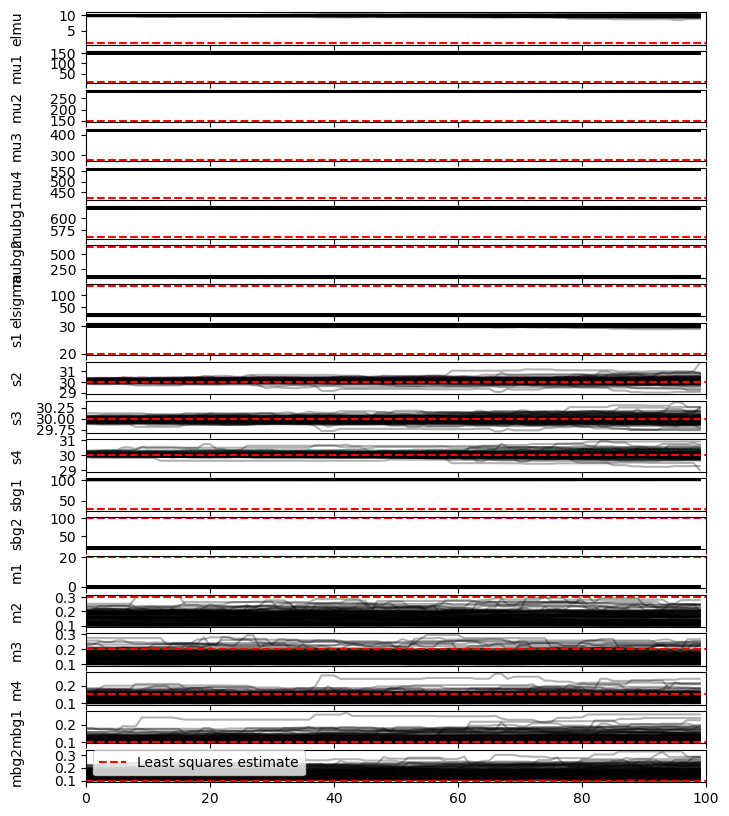

In [31]:
cpo.plot_MCMC_convergences()

## Event-dependent convergence study

In [27]:
assumed_param_values = np.copy(mcparams)

RANDOM_SEED = 1
np.random.seed(seed=RANDOM_SEED)

maxsiz = np.log10(evs.size)
print(evs.size)
print(maxsiz)
evreps=10
n_evs = np.logspace(2, maxsiz, evreps).astype(int)
print(n_evs)
n_evs[-1]=evs.size
print(n_evs)

lse_results = np.zeros((evreps, mcparams.size+1))
lse_errors  = np.zeros((evreps, mcparams.size+1))
mcmc_results = np.zeros((evreps, mcparams.size))
mcmc_errors = np.zeros((evreps, mcparams.size))


lsMinEvents = 10000
mcmcMinEvents = 10
lsMaxEvents = 10000000
mcmcMaxEvents = 90000


rep = 0

for nn in n_evs:
    print("Rep", rep+1, "/", evreps, "|", nn, "/", evs.size)
    print("Subsampling...")
    sse = ema1.subsample(nn)

    sse.lpf = log_prior_function
    sse.pmf = probability_mass_function
    sse.llf = log_likelihood_function


    if nn >= lsMinEvents and nn <= lsMaxEvents:
        print("Least Squares Analysis...")
        sse.least_squares_parameters = copy.deepcopy(lse_starting_parameters)
        sse.calculate_histogram()
        sse.lse_fit()
        #sse.plot_LSE_fit(loglog=False, log=False, xlabel='meV')


        lse_results[rep,:] = sse.get_lse_param_values()
        lse_errors[rep,:] = sse.get_lse_param_errors()
    else:
        print("Skipping Least Squares Analysis (too few events for stable fit)")

    if nn >= mcmcMinEvents and nn <= mcmcMaxEvents:
        print("MCMC Analysis...")
        sse.nwalkers=128 # need to increase this to improve sampling stats quality 
        # (on plots of MCMC_parameter_distribution) 

        sse.theta_seed = same_as_least_squares
        sse.MCMC_fit(nburn=150, niter=150)

        mcmc_results[rep,:], mcmc_errors[rep,:] = sse.get_MCMC_parameters(method='mean')
    else:
        print("Skipping MCMC Analysis (too many events to run on a laptop in sensible time)")

    rep = rep + 1

print("Convergence loop complete.")

2623437
6.418870639382126
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623436]
[    100     309     959    2971    9203   28505   88290  273463  847003
 2623437]
Rep 1 / 10 | 100 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


  0%|                                                   | 0/150 [00:00<?, ?it/s]/Users/phillipbentley/anaconda3/envs/ess/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.53it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:05<00:00, 26.27it/s]


MCMC sampling complete.
stdd 0.10667785650332053
stdd 0.13285164875982733
stdd 0.11297137012517264
stdd 0.10487799449606756
stdd 0.1344628255923826
stdd 0.12251989210015903
stdd 0.0931331454493654
stdd 0.10770085361135338
stdd 0.15522134158761414
stdd 0.0954446422430572
stdd 0.16002780572359368
stdd 0.10489899716706597
stdd 0.07073009259498525
stdd 0.13148064255120606
stdd 0.07883630475270187
stdd 0.045256114642268044
stdd 0.034267496681856094
stdd 0.0374266962958223
stdd 0.02549704518102945
stdd 0.02061644171993111
Rep 2 / 10 | 309 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 23.67it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.78it/s]


MCMC sampling complete.
stdd 0.0881032484773406
stdd 0.09914407954393303
stdd 0.08687859730872649
stdd 0.09059632534861246
stdd 0.07633874306222643
stdd 0.08744166087052443
stdd 0.06549742829722938
stdd 0.07617197316070914
stdd 0.12556449919993645
stdd 0.07237574577886095
stdd 0.08562187235464196
stdd 0.06526294636249415
stdd 0.03787167942312317
stdd 0.10070796938457101
stdd 0.06530231662843038
stdd 0.047836803034576623
stdd 0.041270858142807544
stdd 0.02340240122033624
stdd 0.03103211581796026
stdd 0.04637611546681388
Rep 3 / 10 | 959 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 19.25it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:07<00:00, 20.25it/s]


MCMC sampling complete.
stdd 0.052804828453162526
stdd 0.07746747860199894
stdd 0.1240524434179766
stdd 0.08248133807208911
stdd 0.09956047619127413
stdd 0.057901169388478384
stdd 0.07619781114742454
stdd 0.07713835173322409
stdd 0.1286481452024864
stdd 0.06523179786089654
stdd 0.07570117593748385
stdd 0.10205499148536262
stdd 0.0505317675714555
stdd 0.10884473155213677
stdd 0.08151967684857897
stdd 0.05438304826254825
stdd 0.03337750809130372
stdd 0.027024887667765608
stdd 0.022156468695798216
stdd 0.03196577635181226
Rep 4 / 10 | 2971 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.55it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 12.91it/s]


MCMC sampling complete.
stdd 0.13964132777907406
stdd 0.08583738459310966
stdd 0.07325122716028483
stdd 0.048500657751630136
stdd 0.08476108523770688
stdd 0.12107856758404707
stdd 0.1039877908500589
stdd 0.10504693319576716
stdd 0.06304935528799152
stdd 0.09277715521871766
stdd 0.07865054837229252
stdd 0.09849576046681413
stdd 0.03548694367384644
stdd 0.09107584049343562
stdd 0.08308787013256322
stdd 0.04641283848956328
stdd 0.06269842875307903
stdd 0.0364606347355125
stdd 0.025953451912106427
stdd 0.027362750262035888
Rep 5 / 10 | 9203 / 2623437
Subsampling...
Skipping Least Squares Analysis (too few events for stable fit)
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [00:25<00:00,  5.92it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [00:23<00:00,  6.31it/s]


MCMC sampling complete.
stdd 0.10033194206740007
stdd 0.09907152854533287
stdd 0.096578234898936
stdd 0.08851127659492715
stdd 0.12712694112544162
stdd 0.08819627785069331
stdd 0.14976072517804356
stdd 0.07695433330763314
stdd 0.11768260092034653
stdd 0.10846224552422463
stdd 0.1178980518597814
stdd 0.10003309215264865
stdd 0.041003607605974005
stdd 0.07886171527965281
stdd 0.06934802640856527
stdd 0.04882938510684986
stdd 0.044334075855346135
stdd 0.044311020951407175
stdd 0.01636781399057832
stdd 0.038035212033255085
Rep 6 / 10 | 28505 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [01:07<00:00,  2.22it/s]


Sampling:


100%|█████████████████████████████████████████| 150/150 [01:06<00:00,  2.24it/s]


MCMC sampling complete.
stdd 0.10037978072404329
stdd 0.06739391809577712
stdd 0.1357480567412596
stdd 0.140561757140477
stdd 0.14110349223905508
stdd 0.11942054066207662
stdd 0.17167536588817126
stdd 0.11560039391519088
stdd 0.14800813649833722
stdd 0.2371907911265131
stdd 0.15228120861578204
stdd 0.11803901019900692
stdd 0.04322103999452281
stdd 0.10168872464551675
stdd 0.06584820535567795
stdd 0.05194270380278362
stdd 0.03565447956103621
stdd 0.026212158286127513
stdd 0.023112492115179923
stdd 0.06576209123510984
Rep 7 / 10 | 88290 / 2623437
Subsampling...
Least Squares Analysis...
MCMC Analysis...
MCMC launch
Burn in:


100%|█████████████████████████████████████████| 150/150 [04:04<00:00,  1.63s/it]


Sampling:


100%|█████████████████████████████████████████| 150/150 [03:35<00:00,  1.44s/it]


MCMC sampling complete.
stdd 0.27937308258136706
stdd 0.2893119575118069
stdd 0.7038068208398806
stdd 0.3136978133719556
stdd 0.2624079498411761
stdd 0.4635318040234064
stdd 0.2293556507922499
stdd 0.4170038381088178
stdd 0.26206219731819275
stdd 0.47468417357634524
stdd 0.33583009442217887
stdd 0.31471399577473147
stdd 0.1433842554674433
stdd 0.18829365298933742
stdd 0.0429074579704098
stdd 0.03559659657766864
stdd 0.02537145687142102
stdd 0.03211633084138336
stdd 0.0329691389945148
stdd 0.027792018291086292
Rep 8 / 10 | 273463 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 9 / 10 | 847003 / 2623437
Subsampling...
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop in sensible time)
Rep 10 / 10 | 2623437 / 2623437
Subsampling...
Subsample will return a direct copy of the data instead.
Least Squares Analysis...
Skipping MCMC Analysis (too many events to run on a laptop 

In [28]:
def p_conv_plot(item, param_name='', Bayes=True, LSE=True, savename='', correct=np.inf, ylims=[np.inf, np.inf]):

    # Least squares parameters
    pnams = sse.get_lse_param_names()
    pnam = pnams[item+1]
    
    lsnevs = n_evs
    lsvalues = lse_results[:,item+1]
    lserrs = lse_errors[:,item+1]

    lsmask = lsvalues != 0.0
    lsnevs = lsnevs[lsmask]
    lsvalues = lsvalues[lsmask]
    lserrs = lserrs[lsmask]
    
    lsbtop = lsvalues+lserrs
    lsbbot = lsvalues-lserrs
    lswtop = np.amax(lsvalues)
    lswbot = np.amin(lsvalues)

    # Bayesian parameters
    mcnevs = n_evs
    mcvalues = mcmc_results[:,item]
    mcerrs = mcmc_errors[:,item]

    mcmask = mcvalues != 0.0
    mcvalues = mcvalues[mcmask]
    mcerrs = mcerrs[mcmask]
    mcnevs = mcnevs[mcmask]
    
    
    mcbtop = mcvalues+mcerrs
    mcbbot = mcvalues-mcerrs
    mcwtop = np.amax(mcvalues)
    mcwbot = np.amin(mcvalues)
    
    
    wtop = np.amax([lswtop, mcwtop])
    wbot = np.amin([lswbot, mcwbot])

    wspan = wtop - wbot
    wpad = wspan * 0.1
    wtop = wtop + np.abs(wpad)
    wbot = wbot - np.abs(wpad)

        
    fig, ax = plt.subplots()
    if LSE:
        ax.plot(lsnevs, lsvalues, color='blue', label='LSE')
        ax.fill_between(lsnevs, lsbbot, lsbtop, color='blue', alpha=0.15, label='LSE std. err')
        ax.set_ylim([wbot, wtop])
        ax.set_xlabel("# events")
        ax.set_ylabel(pnam + "Value")
        if param_name != '':
            ax.set_ylabel(param_name)

    if Bayes:
        ax.plot(mcnevs, mcvalues, color='red', label='Bayes')
        ax.fill_between(mcnevs, mcbbot, mcbtop, color='red', alpha=0.15, label='Bayes std. err')

    if np.isfinite(correct):
        xmin=np.amin(mcnevs)
        xmax=np.amax(lsnevs)
        plt.hlines(correct, xmin, xmax, label='Visual estimate', ls='--', color='orange')


    if np.isfinite(ylims).all():
        plt.ylim(ylims)
    
    
    plt.xscale('log')
    plt.yscale('linear')
    ax.legend()

        

    if savename != '':
        plt.savefig(savename, dpi=600, bbox_inches='tight')
        plt.show()
    
    #print(sse.get_lse_param_names())

    

### Elastic Line Parameters

What are the correct values?  lets inspect the kde of the full data set.

Calculating KDE
   - linear scale
nx 224
slice size 0.5880000000000001


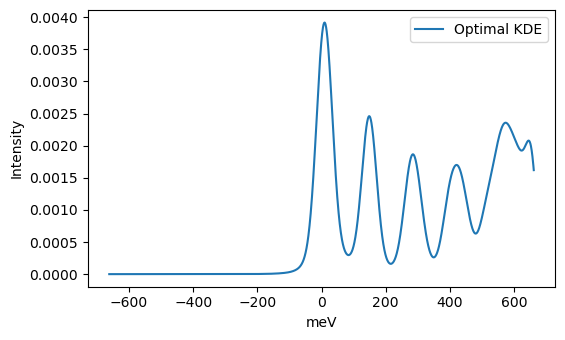

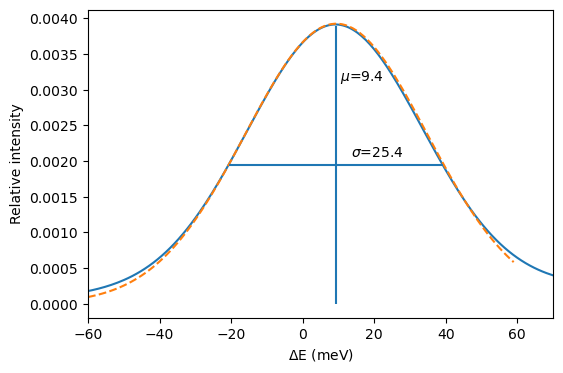

In [34]:
ema1.plot_kde(loglog=False,log=False, xlabel='meV', method='silverman')

mu=9.4
sig=25.4
norm=4.0
ht=0.0039

px=np.arange(-60,60,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([-60,70])
plt.savefig('arcsFigs/arcs_fulldata_kde_elastic.png', dpi=600, bbox_inches='tight')
plt.show()

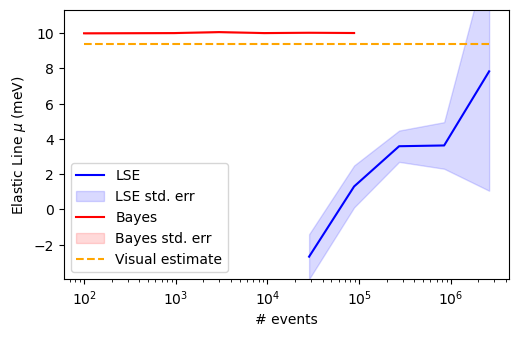

In [35]:
parameter_no = 0
p_conv_plot(parameter_no, param_name='Elastic Line $\mu$ (meV)', savename='arcsFigs/arcs_elastic_mu.png', correct=9.4)
#p_conv_plot(parameter_no, LSE=False)

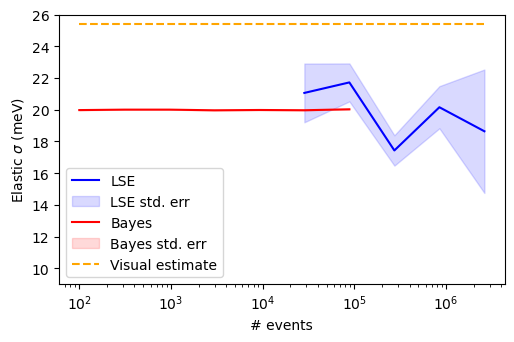

In [36]:
parameter_no = 7
p_conv_plot(parameter_no, param_name='Elastic $\sigma$ (meV)', savename='arcsFigs/arcs_elastic_sigma.png', correct=25.4, ylims=[9, 26])
#p_conv_plot(parameter_no, LSE=False)

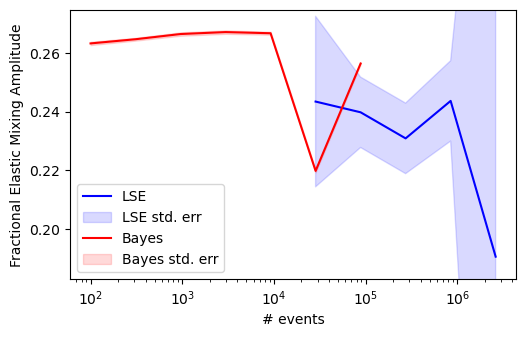

In [37]:
parameter_no = 14
p_conv_plot(parameter_no, param_name='Fractional Elastic Mixing Amplitude', savename='arcsFigs/arcs_elastic_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Excitation Line Parameters

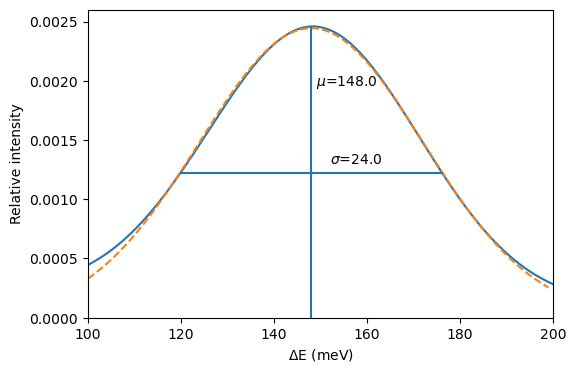

In [39]:
mu=148.0
sig=24.0
norm=6.8
ht=0.00245

px=np.arange(100,200,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([100,200])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex1.png', dpi=600, bbox_inches='tight')
plt.show()

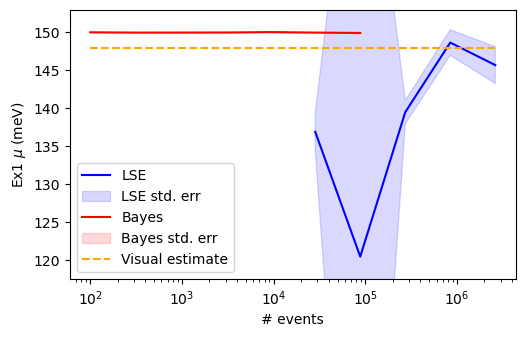

In [40]:
parameter_no = 1
p_conv_plot(parameter_no, param_name='Ex1 $\mu$ (meV)', savename='arcsFigs/arcs_ex1_mu.png', correct=148.0)
#p_conv_plot(parameter_no, LSE=False)

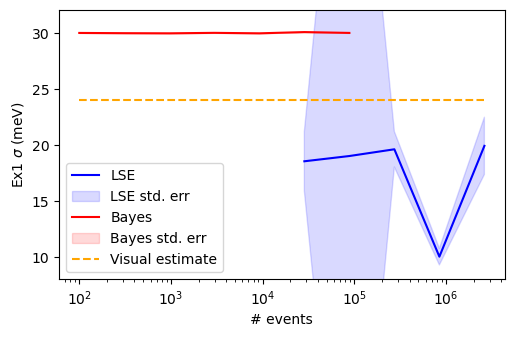

In [41]:
parameter_no = 8
p_conv_plot(parameter_no, param_name='Ex1 $\sigma$ (meV)', savename='arcsFigs/arcs_ex1_sigma.png', correct=24)
#p_conv_plot(parameter_no, LSE=False)

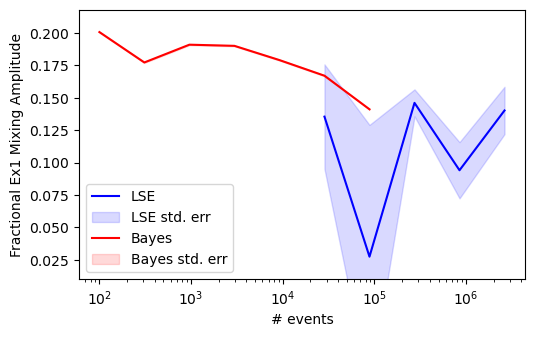

In [42]:
parameter_no = 15
p_conv_plot(parameter_no, param_name='Fractional Ex1 Mixing Amplitude', savename='arcsFigs/arcs_ex1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Excitation Line Parameters

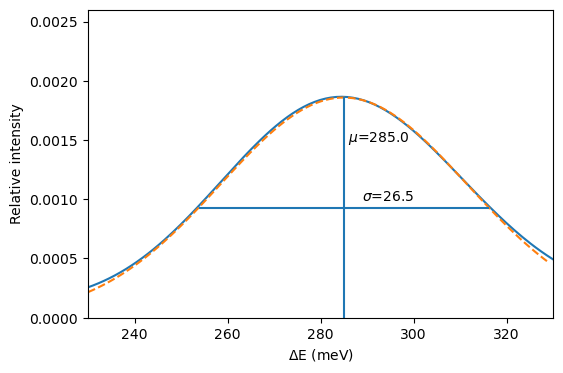

In [43]:
mu=285.0
sig=26.5
norm=8.1
ht=0.00186

r1=230
r2=330

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex2.png', dpi=600, bbox_inches='tight')
plt.show()

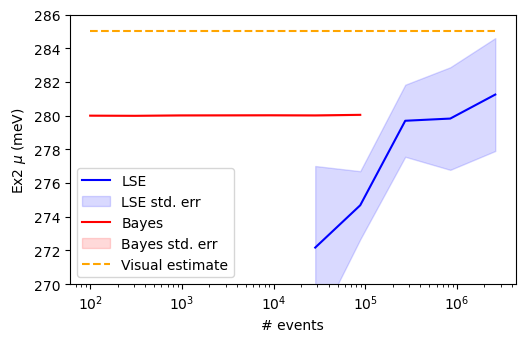

In [44]:
parameter_no = 2
p_conv_plot(parameter_no, param_name='Ex2 $\mu$ (meV)', savename='arcsFigs/arcs_ex2_mu.png', correct=285.0, ylims=[270, 286])
#p_conv_plot(parameter_no, LSE=False)

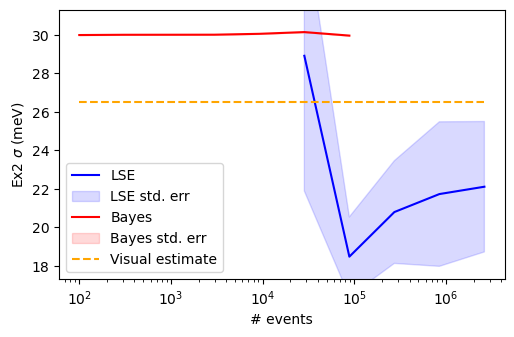

In [45]:
parameter_no = 9
p_conv_plot(parameter_no, param_name='Ex2 $\sigma$ (meV)', savename='arcsFigs/arcs_ex2_sigma.png', correct=26.5)
#p_conv_plot(parameter_no, LSE=False)

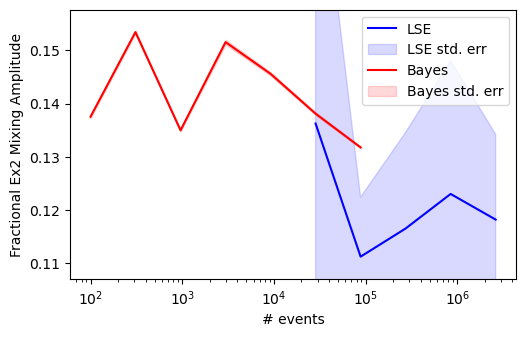

In [46]:
parameter_no = 16
p_conv_plot(parameter_no, param_name='Fractional Ex2 Mixing Amplitude', savename='arcsFigs/arcs_ex2_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Third Excitation Line Parameters

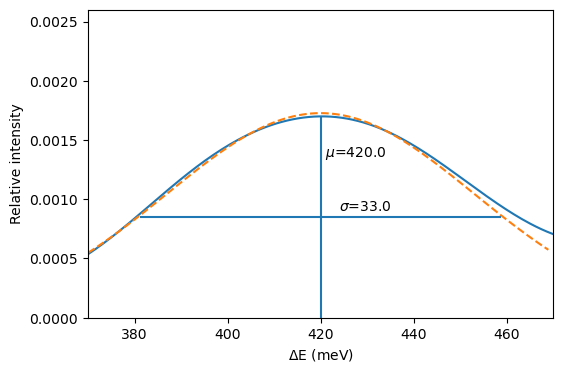

In [47]:
window_mu=420.0
mu=420.0
sig=33.0
norm=7.0
ht=0.0017

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex3.png', dpi=600, bbox_inches='tight')
plt.show()

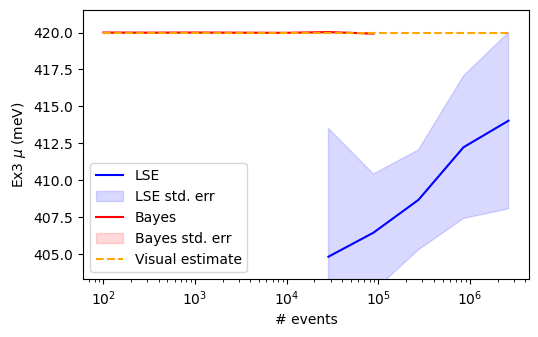

In [48]:
parameter_no = 3
p_conv_plot(parameter_no, param_name='Ex3 $\mu$ (meV)', savename='arcsFigs/arcs_ex3_mu.png', correct=420.0)
#p_conv_plot(parameter_no, LSE=False)

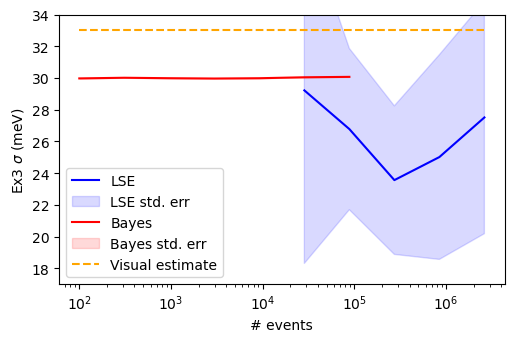

In [49]:
parameter_no = 10
p_conv_plot(parameter_no, param_name='Ex3 $\sigma$ (meV)', savename='arcsFigs/arcs_ex3_sigma.png', correct=33.0, ylims=[17, 34])
#p_conv_plot(parameter_no, LSE=False)

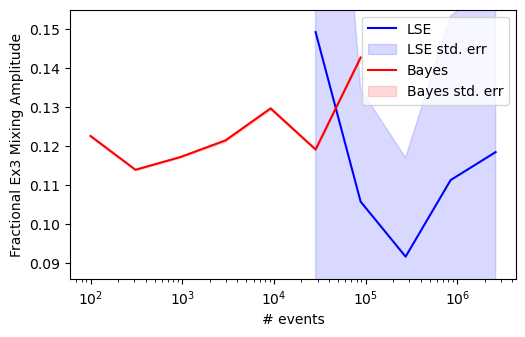

In [50]:
parameter_no = 17
p_conv_plot(parameter_no, param_name='Fractional Ex3 Mixing Amplitude', savename='arcsFigs/arcs_ex3_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Fourth Excitation Line Parameters

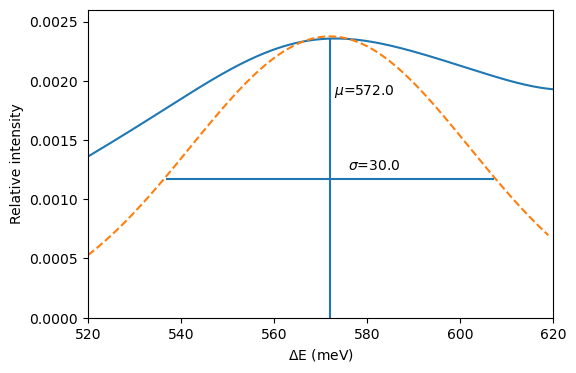

In [60]:
window_mu=570.0
mu=window_mu+2
sig=30.0
norm=5.6
ht=0.00235

r1=window_mu-50
r2=window_mu+50

px=np.arange(r1,r2,1)
nrm = sp.stats.norm(loc=mu,scale=sig)
py=nrm.pdf(px)/norm

fig,ax=plt.subplots()
plt.plot(ema1.kdex, ema1.kdey)
plt.plot(px, py, ls='--')
plt.xlabel('$\Delta$E (meV)')
plt.ylabel('Relative intensity')
plt.vlines(mu, 0.0, ht)
plt.hlines(ht/2.0, mu-2.355*sig/2.0, mu+2.355*sig/2.0)
ax.text(mu+1, ht*0.8, "$\mu$=" + str(mu))
ax.text(mu+4, ht*0.53, "$\sigma$=" + str(sig))
fig.set_size_inches(6,4)
plt.xlim([r1,r2])
plt.ylim([0.0, 0.0026])
plt.savefig('arcsFigs/arcs_fulldata_kde_ex4.png', dpi=600, bbox_inches='tight')
plt.show()

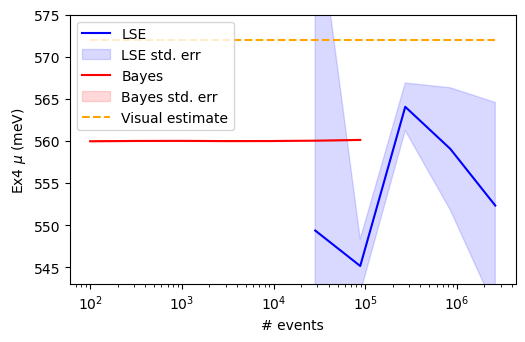

In [52]:
parameter_no = 4
p_conv_plot(parameter_no, param_name='Ex4 $\mu$ (meV)', savename='arcsFigs/arcs_ex4_mu.png', correct=572.0, ylims=[543, 575])
#p_conv_plot(parameter_no, LSE=False)

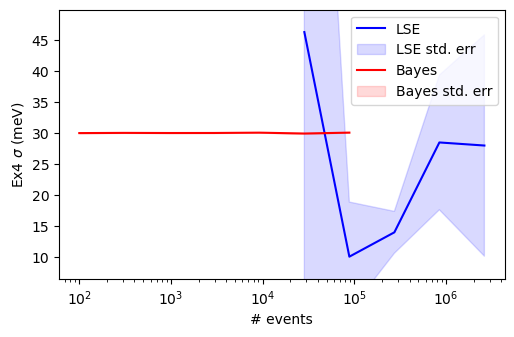

In [53]:
parameter_no = 11
p_conv_plot(parameter_no, param_name='Ex4 $\sigma$ (meV)', savename='arcsFigs/arcs_ex4_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

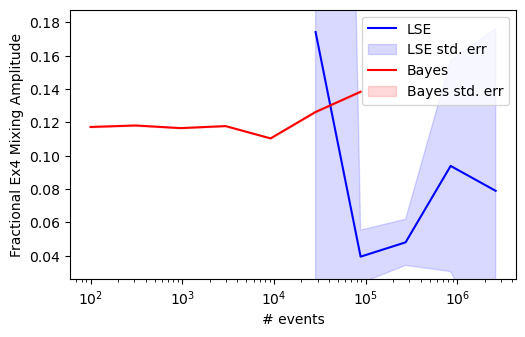

In [54]:
parameter_no = 18
p_conv_plot(parameter_no, param_name='Fractional Ex4 Mixing Amplitude', savename='arcsFigs/arcs_ex4_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### First Background Term Parameters 

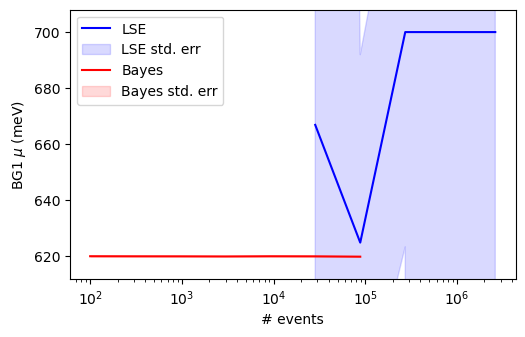

In [55]:
parameter_no = 5
p_conv_plot(parameter_no, param_name='BG1 $\mu$ (meV)', savename='arcsFigs/arcs_BG1_mu.png')
#p_conv_plot(parameter_no, LSE=False)

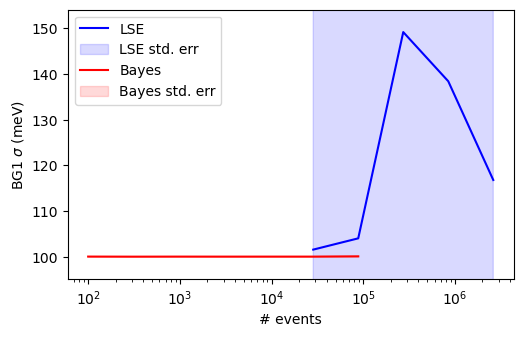

In [56]:
parameter_no = 12
p_conv_plot(parameter_no, param_name='BG1 $\sigma$ (meV)', savename='arcsFigs/arcs_BG1_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

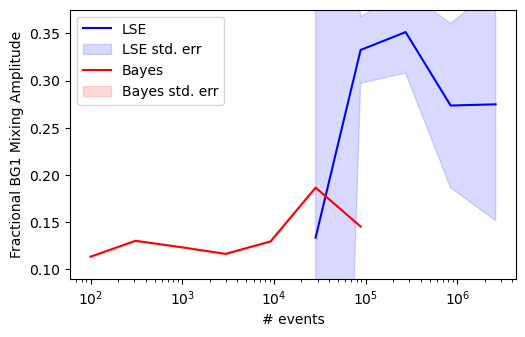

In [57]:
parameter_no = 19
p_conv_plot(parameter_no, param_name='Fractional BG1 Mixing Amplitude', savename='arcsFigs/arcs_BG1_amplitude.png')
#p_conv_plot(parameter_no, LSE=False)

### Second Background Term Parameters

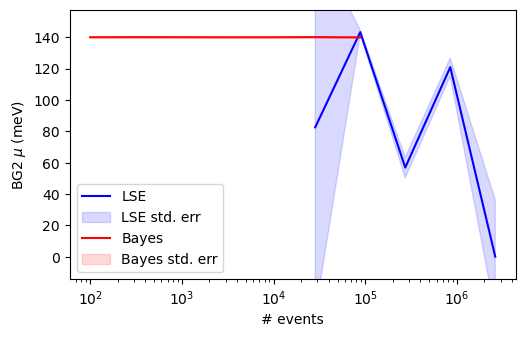

In [58]:
parameter_no = 6
p_conv_plot(parameter_no, param_name='BG2 $\mu$ (meV)', savename='arcsFigs/arcs_BG2_mu.png')
#p_conv_plot(parameter_no, LSE=False)

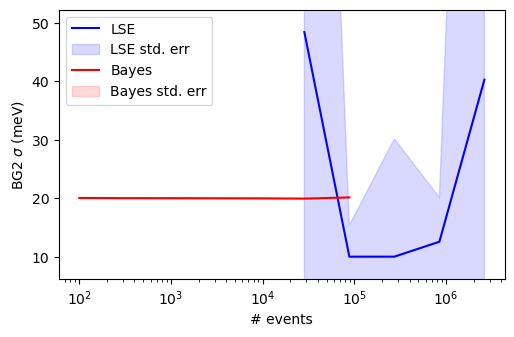

In [59]:
parameter_no = 13
p_conv_plot(parameter_no, param_name='BG2 $\sigma$ (meV)', savename='arcsFigs/arcs_BG2_sigma.png')
#p_conv_plot(parameter_no, LSE=False)

The weight of the second background term is computed from 1-sum(other_weights) so it has no individual parameter.

## Important Questions and Possible Answers

1. Why does the parameter noise obviously exceed the reported variance for the MCMC parameters?

Probably because the random subsample of events is at each step random.  The variance is the *statistical* variance as sampled by MCMC within the data set, whilst the subsampling of the events for low numbers of events provides a systematic shift of that parameter space from analysis to analysis.  The correct variance would probably be obtained by re-subsampling many times and computing the mean and standard error of the obtained parameters.  This is going to be very slow and would require a cluster job in the future to do that work.

2. Why does the variance on some LSE parameters increase with increasing events?

Probably because the LSE is unstable with so many parameters, and it is getting stuck in a local optimum.  If you look at some of the parameters the stated variances for these parameters are enormous, so the LSE estimates from the chi-squared surface curvature are probably wrong.  Since many of the parameter values are so close to those obtained from MCMC I suspect that monte-carlo sampling the LSE parameter space as described above might yield more realistic parameter variances.
